In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.cm
import util
import json
from fit import get_weights
import itertools

In [16]:
print "test"

test


In [17]:
exp_spectrum, bins, exp_lnA, lnA_bins = util.load_exp_data()

## Load meta data

In [19]:
#load registry and fit data
with open("registry.json") as f:
    registry_data = json.load(f)
with open("fits.json") as f:
    fit_data = json.load(f)
    

fit_data.sort(key=lambda fit: fit["m"])

In [20]:
indices = [[68], [70], [72], [73], [74]]

In [21]:
sampling_p = registry_data[indices[0][0]]["p"]
for index in itertools.chain(*indices):
    assert registry_data[index]["p"] == sampling_p
    #assert registry_data[index]["m"] == registry_data[indices[0]]["m"]
    
p = -2.0 #target p after reweighting
#registry_data[index]["m"]

In [22]:
fit_data_new = []

for fit in fit_data:
    if fit["indices"] in indices and fit["lnA_fit_weight"] == 5.:
        fit_data_new.append(fit)
        
fit_data = fit_data_new

In [14]:
#find a fitting fit
for fit in fit_data:
    if fit["p"] == registry_data[indices[0]]["p"]  and  fit["m"] == registry_data[indices[0]]["m"] and fit["indices"] == indices:
        params = fit["params"]
        break

## Comparison Plot

This plot does not use the fit selected above, but instead plots all fits into a single diagram for comparison.

In [23]:
def filter_data (mcdata):
    filter = np.logical_and (
                        mcdata["E"] > 1e-1,
                        util.read_particle_id(mcdata["ID"])[0] == "nucleus")
    return mcdata.compress(filter)


In [24]:
mc_datasets = [util.read_from_indices("nucleons", fit["indices"]) for fit in fit_data]

Reading data:
   1488968 items read.
Reading data:
   1498781 items read.
Reading data:
   1526069 items read.
Reading data:
   1526297 items read.
Reading data:
   1513707 items read.


In [25]:
mc_datasets = [filter_data(mcdata) for mcdata in mc_datasets]

In [26]:
def binstep (axes, bins, counts, *args, **kwargs):
    
    return axes.step(bins, np.concatenate([np.array([counts[0]]), counts]), *args, **kwargs)

In [27]:
%matplotlib inline

exp = util.load_exp_data()

_, a = plt.subplots(2, sharex=True)

viridis = matplotlib.cm.get_cmap("viridis")
curve_color_coords = np.linspace(0., 1., len(fit_data))

centers = exp.exp_spectrum[:, 0] - 18

for (i, fit) in enumerate(fit_data):
    mc_data = mc_datasets[i]
    binstep(a[0], np.minimum(exp.bins, 2.2), reweight(mc_data, **fit["params"])*(10**centers)**2 * 1e36, label="m={}".format(fit["m"]), color=viridis(curve_color_coords[i]), where="pre")#, linestyle="--")
    binstep(a[1], np.minimum(exp.lnA_bins, 1.7), reweight_massdist(mc_data, **fit["params"]), label="m={}; p={:.2f}".format(fit["m"], fit["params"]["p"]), color=viridis(curve_color_coords[i]), where="pre")
    
np.save("/tmp/reweight_test.npy", reweight(mc_data, **fit["params"])*(10**exp.bins[:-1])**2)

a[0].errorbar(centers, exp.exp_spectrum[:, 1] * (10**centers)**2 * 1e36, yerr=(exp_spectrum[:, 2]+exp_spectrum[:, 3])/2 * (10**centers)**2 * 1e36, linestyle="", label="Auger", color="k", marker=".")
a[0].semilogy()
a[0].set_ylabel(u"E³ J / (eV² m⁻² s⁻¹ sr⁻¹)")
a[0].legend(loc="lower left", ncol=3)

lnA_error = np.sqrt(exp_lnA["mlnAstat"]**2  +  ((abs(exp_lnA["mlnA"] - exp_lnA["mlnAsyslo"]) + abs(exp_lnA["mlnA"] - exp_lnA["mlnAsyshi"])) / 2)**2 )
a[1].errorbar(exp.exp_lnA["logE"]-18, exp.exp_lnA["mlnA"], yerr=lnA_error, label="Auger", color="k", linestyle="", marker=".")
a[1].set_xlabel(u"log (E / EeV)")
a[1].set_ylabel(u"$\\langle \\ln A\\rangle$")
#a[1].legend()

plt.savefig("different_ms.svg")
plt.savefig("different_ms.pdf")
plt.show()    

## Neutrinos

### Load

In [28]:
def filter_neutrinos(neutrinos):
    return neutrinos.compress((neutrinos["E"] > 1e-1) & \
                               ((abs(neutrinos["ID"]) == 14) | (abs(neutrinos["ID"]) == 16) | (abs(neutrinos["ID"]) == 18)))

In [29]:
neutrino_datasets = [util.read_from_indices("neutrinos", fit["indices"]) for fit in fit_data]
neutrino_datasets = [filter_neutrinos(neutrinos) for neutrinos in neutrino_datasets]

Reading data:
  15329553 items read.
Reading data:
  18618845 items read.
Reading data:
  21910451 items read.
Reading data:
  23955921 items read.
Reading data:
  21325593 items read.


### Plot

In [30]:
get_weights_neutrinos(neutrino_datasets[i], mc_datasets[i], sampling_p, fit_data[i]["params"]).shape

(6676073,)

In [41]:
bounds_E = np.array([5.011870e+06, 6.309570e+06, 7.943280e+06, 1.995260e+07, 5.011870e+07, 1.258930e+08, 3.162280e+08, 7.943280e+08, 1.995260e+09, 5.011870e+09, 1.258930e+10, 3.162280e+10, 7.943280e+10
][5:])
bounds_phi = np.array([1.135115e-08, 1.190701e-08, 1.260912e-08, 1.859683e-08, 2.134614e-08, 2.073100e-08, 1.783418e-08, 1.981252e-08, 3.069675e-08, 4.256704e-08, 7.334558e-08, 1.184359e-07, 2.651410e-07
][5:])

In [47]:
%matplotlib inline
plt.semilogy()
for i in range(5):
    plt.hist(np.log10(neutrino_datasets[i]["E"]), bins=np.linspace(-1, 2, 31), log=True, weights=(fit_data[i]["params"]["a"] * get_weights_neutrinos(neutrino_datasets[i], mc_datasets[i], sampling_p, fit_data[i]["params"]) * neutrino_datasets[i]["E"]**2 * 1e5), label="m={}".format(fit_data[i]["m"]), histtype="step", color=viridis(curve_color_coords[i])) #The 1e5 is a scaling factor so we get a result in the right units

plt.plot(np.log10(bounds_E/1e9), bounds_phi, color="k", label="IceCube 2017 upper limit", lw=2.)
plt.xlabel(u"$E_\\nu / EeV$")
plt.ylabel(u"Eν² · φ (Eν) / (GeV / (cm² s sr)) ")
plt.legend(loc="lower center")
plt.savefig("neutrinos.svg")
plt.savefig("neutrinos.pdf")
plt.show()

## Nucleons

### Load

In [9]:
nucleons = util.read_from_indices("nucleons", indices)
nucleons = nucleons.compress(nucleons["E"] > 1e-5)
#nucleons = nucleons.compress(nucleons["D"] ==  3.58904)
name0, A0, Z0 = util.read_particle_id(nucleons["ID"])

Reading data:


IOError: [Errno 2] No such file or directory: 'data/nucleons-[67, 68].txt'

### Plot

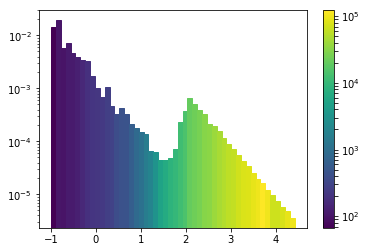

In [15]:
%matplotlib inline
from IPython.html import widgets
from IPython import display

var = 0.

def update (name, new):
    global var
    display.clear_output(wait=True)
    util.augmented_hist(np.log10(nucleons["E0"]), bins=50, log=True, weights=get_weights(nucleons, sampling_p, {"wP": new, "wHe": 0., "wCNO": 0., "Rmax":1e8, "p":2.0}))
    plt.show()

test = widgets.FloatSliderWidget(value=params["wFe"])
test.on_trait_change(update, "value")
display.display(test)

In [1]:
%matplotlib inline
#plt.semilogy()
util.augmented_hist(np.log10(nucleons["E"]), bins=50, log=True, weights=get_weights(nucleons, sampling_p, {"wP": 00., "wHe": 00., "wCNO": 0., "Rmax":1e8, "p":2.0}))
#plt.hist2d(np.log10(nucleons["E0"]), np.log10(nucleons["E"]), norm=mpc.SymLogNorm(1), bins=120)
#plt.colorbar()
plt.show()

NameError: name 'util' is not defined

## Additional helper functions (run these first!)

In [18]:
def get_weights_nomix (mc_data, simulation_p, params):

    weights = mc_data["E0"]**(-simulation_p-params["p"]) #XXX: params["p"] is currently defined to be negative (ie implicitly multiplied by -1), while simulation_p isn't
    
    name0, A0, Z0 = util.read_particle_id(mc_data["ID0"])
    
    R = mc_data["E0"] / Z0 #NOTE: since E0 is in EeV, R is implicitly in units 1e18 as well
    #... which is handy, because particle_Rmax_base is in EV too, so we don't need to convert here.
    weights[R > params["Rmax"]] = 0.


    return weights


def get_weights (mc_data, simulation_p, params):
    
    weights = get_weights_nomix(mc_data, simulation_p, params)
        
    iP, iHe, iCNO, iSi, iFe = get_element_indices(mc_data)
    
    weights[iP] *= params["wP"]/100.
    weights[iHe] *= params["wHe"]/100.
    weights[iCNO] *= params["wCNO"]/100.
    weights[iSi] *= params["wSi"]/100.
    weights[iFe] *= (100 - params["wP"] - params["wHe"] - params["wCNO"] - params["wSi"])/100.
    
    #weights[np.isnan(weights)] = 0.
    
    return weights

def get_element_indices (mc_data):
                
    name0, A0, Z0 = util.read_particle_id(mc_data["ID0"])
    is_nucleus = name0 == "nucleus"
    
    iP = (Z0==1) & is_nucleus
    iHe = (Z0==2) & is_nucleus
    iCNO = ((Z0==6) | (Z0==7) | (Z0==8)) & is_nucleus
    iSi = (Z0==14) & is_nucleus
    iFe = (Z0==26) & is_nucleus
    
    return iP, iHe, iCNO, iSi, iFe
    

def get_weights_neutrinos (neutrino_data, nucleon_data, sampling_p, params):

    nucleon_base_weights = get_weights_nomix(nucleon_data, sampling_p, params)
    niP, niHe, niCNO, niSi, niFe = get_element_indices(nucleon_data)
    
    weights = get_weights_nomix(neutrino_data, sampling_p, params)
    viP, viHe, viCNO, viSi, viFe = get_element_indices(neutrino_data)
    
    weights[viP] *= params["wP"]/100.
    weights[viHe] *= params["wHe"]/100.
    weights[viCNO] *= params["wCNO"]/100.
    weights[viSi] *= params["wSi"]/100.
    weights[viFe] *= (100 - params["wP"] - params["wHe"] - params["wCNO"] - params["wSi"])/100.
    
    weights[np.isnan(weights)] = 0.
    
    return weights


def reweight (mc_data, **params):

    weights = get_weights(mc_data, sampling_p, params)
    np.save("/tmp/weights_test.npy", weights)
    hist = np.bincount(np.digitize(np.log10(mc_data["E"]), bins=bins), weights=weights, minlength=len(bins)) * params["a"]
    hist = hist[1:] #ignore first bin, for compatibility with np.histogram (technically, we'd have to ignore the last bin as well, but in this case, that extends to infinity anyways.
    #print params["p"], params["a"]

    return hist


def reweight_massdist (mc_data, **params):
    
    particle_ids = util.read_particle_id(mc_data["ID"])

    weights = get_weights(mc_data, sampling_p, params)
    binned = np.digitize(np.log10(mc_data["E"]), bins=lnA_bins)
    numbers = np.bincount(binned, weights=weights, minlength=len(lnA_bins))[1:]
    sums = np.bincount(binned, weights=weights*np.log(particle_ids[1]), minlength=len(lnA_bins))[1:]

    result = sums/numbers
    result[numbers == 0] = 0.

    return result

